# Schooling in Xenopus tadpoles

Playground to troubleshoot analysis procedures.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import scipy.stats as stats
from typing import List,Tuple

In [2]:
def preProcess(d):
    d.columns = ['Tad']+[d.columns[i].replace(' ','') for i in range(1,len(d.columns))] # Remove spaces in column names
    d.insert(1, 'Frame', 0)
    
    for i in range(1,d.shape[0]):
        if d.loc[i,'Tad']<d.loc[i-1,'Tad']:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']+1
        else:
            d.loc[i,'Frame'] = d.loc[i-1,'Frame']
    # Note that d['Frame'][i] wouldn't have worked because of chain slicing: applying 2nd slice after the 1st would
    # have created a copy of the dataframe, and so wouldn't have transformed the original dataframe
    d.Frame = d.Frame.astype(int) # Not sure why it becomes float, but I don't like it      
    return d

data = pd.read_csv('data/control.csv')
data = preProcess(data)
print(data[:5])

   Tad  Frame  Area  Min  Min  Max      X       Y
0    1      0     0  215  215  215  7.391  14.783
1    2      0     0  128  128  128  7.232  14.643
2    3      0     0  239  239  239  8.850  14.623
3    4      0     0  156  156  156  8.670  14.443
4    5      0     0  236  236  236  7.751  12.426


Standard ImageJ format. X and Y are coordinates; every odd row is a tadpole head; every odd row is a tail. The first row goes from 1 to 2n (where n is the number of tadpoles in each frame), then starts anew. We manually add a frame counter.

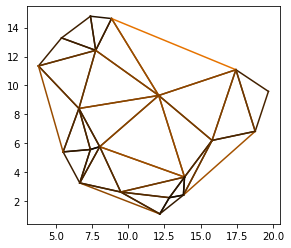

In [3]:
def getNFrames(d):
    return max(d.Frame)

def extractTads(d,frame):
    '''Splits the data into xy of heads and relative xy of tails'''
    xy = d.loc[d.Frame==frame,['X','Y']].to_numpy()
    heads = xy[0::2,:]
    tails = xy[1::2,:]-heads
    return pd.DataFrame({'x':heads[:,0] , 'y':heads[:,1] , 'tx':tails[:,0] , 'ty':tails[:,1]})  

def findNeighbors(tads): # Returns a new data frame, for edges
    '''Triangulates the field, finds "neighbors". No thresholding of distance!'''
    xy = tads[['x','y']]
    tri = scipy.spatial.Delaunay(xy,qhull_options="QJ").simplices # Help says that this "QJ" is needed if you want to
                                                                  # have all tadpoles in the output (even lonely ones)
    listOfPairs = [] # Array of tuples to describe all pairs of points
    for i in range(tri.shape[0]): # Go through all edges of Delaunay triangles, include each one only once
        t = [tuple(tri[i,[0,1]]) , tuple(tri[i,[1,2]]) , tuple(tri[i,[2,0]])]
        for p in t:
            if not p in listOfPairs:
                listOfPairs += [p]
    out = pd.DataFrame({'i':[a for (a,b) in listOfPairs] , 'j':[b for (a,b) in listOfPairs]})
    return out

def findDistances(tads,pairs):
    '''Distances between pairs of tadpoles'''
    xy = tads[['x','y']].values
    dist = [np.linalg.norm(xy[p[0],]-xy[p[1],]) for p in pairs[['i','j']].values.tolist()]
    pairs['dist'] = dist
    return pairs


tads = extractTads(data,frame=0)
pairs = findNeighbors(tads)
pairs = findDistances(tads,pairs)

# Test figure to see whether distances are distances
fig = plt.figure()
ax = fig.add_subplot(111)
xy = tads[['x','y']].values
for i in range(len(pairs)):
    p = pairs[['i','j']].values.tolist()[i]
    #ax.plot([xy[p[0],0] , xy[p[1],0]],[xy[p[0],1] , xy[p[1],1]]) # Point
    ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([1,0.5,0])*pairs['dist'].iloc[i]/pairs[['dist']].max().values*0.9) # Same as above, but weirdly written ;)
ax.set_aspect('equal')

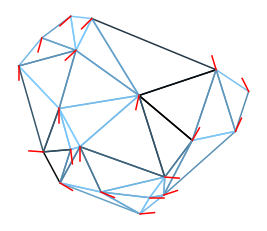

In [4]:
def findAngles(tads,pairs):
    '''Angles between pairs of tadpoles'''
    tails = tads[['tx','ty']].values # Go from pandas to lists, to effectively utilize list comprehension
    norms = [np.linalg.norm(tails[i,]) for i in range(tails.shape[0])]
    angle = [np.arccos(np.dot(tails[p[0],],tails[p[1],])/(norms[p[0]]*norms[p[1]])) 
             for p in pairs[['i','j']].values.tolist()]
    pairs['angle'] = angle
    return pairs

def niceTadFigure(ax,tads,pairs):
    xy = tads[['x','y']].values
    tails = tads[['tx','ty']].values
    ang = pairs[['angle']].values
    for i in range(len(pairs)):
        p = pairs[['i','j']].values.tolist()[i]
        ax.plot(*([xy[p[i],_] for i in range(2)] for _ in range(2)),
           color=np.array([0.5,0.8,1])*(1-ang[i]/max(ang))) # Same as above, but weirdly written ;)
    for i in range(xy.shape[0]):
        nm = np.linalg.norm(tails[i,])
        ax.plot(xy[i,0]+[0,tails[i,0]/nm], xy[i,1]+[0,tails[i,1]/nm] , '-',color='red')
    ax.set_aspect('equal')
    ax.axis('off')

pairs = findAngles(tads,pairs)
    
fig = plt.figure()
ax = fig.add_subplot(111)
niceTadFigure(ax,tads,pairs)

,i,j,dist,angle,frame
0,16,17,5.154548,0.817645,0
1,17,6,5.622530,2.624425,0
2,6,16,4.820149,2.841115,0
3,2,3,2.508651,0.559125,0
4,3,4,2.511861,0.266252,0


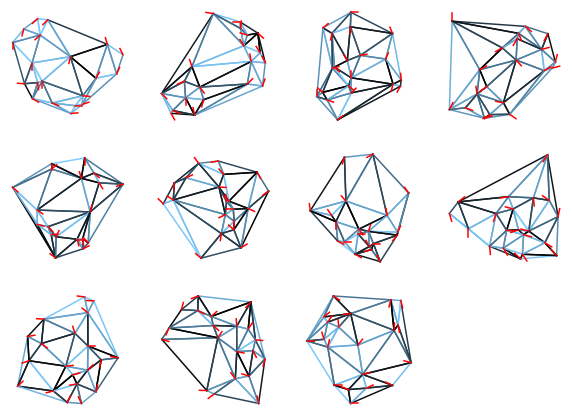

In [10]:
# Now analyze everything, and populate a data frame
def processEverything(d):
    fig = plt.figure(figsize=(10,10))

    fullDf = pd.DataFrame()
    for iframe in range(getNFrames(d)):
        tads = extractTads(d,frame=iframe)
        pairs = findNeighbors(tads)
        pairs = findDistances(tads,pairs)
        angl = findAngles(tads,pairs)

        pairs['frame'] = [iframe]*len(pairs)
        fullDf = fullDf.append(pd.DataFrame(pairs))    

        ax = fig.add_subplot(4,4,iframe+1)    
        niceTadFigure(ax,tads,pairs)
    return fullDf
    
out = processEverything(data)
out.head(5)

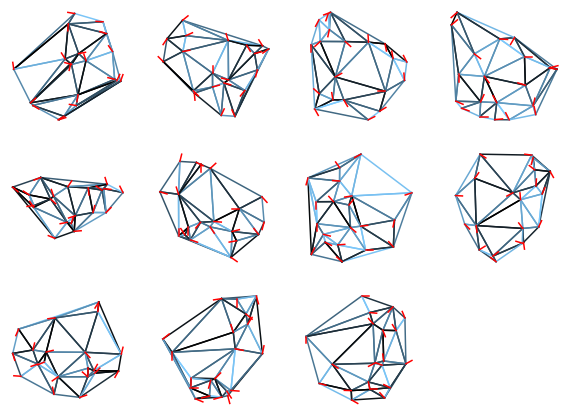

In [14]:
# Time to reshuffle
def shuffleTads(d):
    '''Reshuffles tadpoles within between frames'''
    nd = d.copy()
    p = np.random.permutation(len(d)//2)
    i = [a for sublist in [[2*j,2*j+1] for j in p] for a in sublist] # Looks like [2 3 0 1 4 5] etc. Weird syntax, huh?
    nd = nd.iloc[i]
    nd = nd.reset_index()
    nd['Frame'] = d['Frame'] # After everything was reshuffled, reset frame numbers
    return nd

nd = shuffleTads(data)
out2 = processEverything(nd)

Ttest_indResult(statistic=-1.3336856929688963, pvalue=0.18246184613362776)

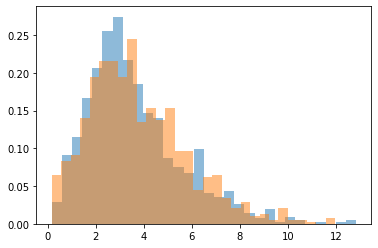

In [30]:
# Compare proper and randomized distances
d = out['dist'].values
d2 = out2['dist'].values

plt.hist(d , bins=30, density=True, alpha=0.5);
plt.hist(d2, bins=30, density=True, alpha=0.5);

stats.ttest_ind(d,d2)

Ttest_indResult(statistic=-3.0741896491486522, pvalue=0.0021398561562483765)

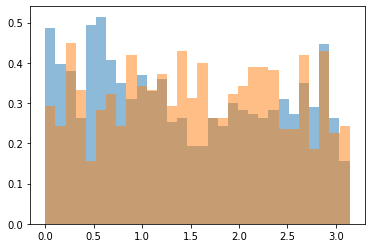

In [33]:
# Compare proper and randomized angles
a = out['angle'].values
a2 = out2['angle'].values

plt.hist(a , bins=30, density=True, alpha=0.5);
plt.hist(a2, bins=30, density=True, alpha=0.5);

stats.ttest_ind(a,a2) # This is actually incorrect, because circular statistics. Remake!